In [1]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm

%matplotlib inline

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from mpl_toolkits.mplot3d import Axes3D

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable



In [28]:
%matplotlib inline

In [2]:
df = pd.read_csv('data/cfl1.csv')

In [3]:
df.drop(['Unnamed: 0'],inplace=True, axis=1)

df.head()

InvoiceNo zipcode               Description  Quantity          InvoiceDate  \
0     536365  85123A     Winnipeg Blue Bombers         6  2010-12-01 08:26:00   
1     536365   71053                  BC Lions         6  2010-12-01 08:26:00   
2     536365  84406B  Saskatchewan Roughriders         8  2010-12-01 08:26:00   
3     536365  84029G       Hamliton Tiger-cats         6  2010-12-01 08:26:00   
4     536365  84029E       Hamliton Tiger-cats         6  2010-12-01 08:26:00   

   UnitPrice  CustomerID  Location  amount First_Fans  \
0      255.0       17850  Edmonton  1530.0        Yes   
1      339.0       17850  Montreal  2034.0        Yes   
2      275.0       17850   Winipeg  2200.0        Yes   
3      339.0       17850  Edmonton  2034.0        Yes   
4      339.0       17850  Montreal  2034.0        Yes   

   days_since_last_purchase  
0                     374.0  
1                     374.0  
2                     374.0  
3                     374.0  
4                     374.0

In [4]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1, sort=True)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=True)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str

details = rstr(df)
display(details.sort_values(by='missing ration', ascending=False))

Data shape: (397884, 11)
___________________________
Data types:
 object     5
int64      3
float64    3
Name: types, dtype: int64
___________________________


types  counts  distincts  nulls  missing ration  \
CustomerID                  int64  397884       4338      0             0.0   
Description                object  397884          9      0             0.0   
First_Fans                 object  397884          2      0             0.0   
InvoiceDate                object  397884      17282      0             0.0   
InvoiceNo                   int64  397884      18532      0             0.0   
Location                   object  397884          9      0             0.0   
Quantity                    int64  397884        301      0             0.0   
UnitPrice                 float64  397884        440      0             0.0   
amount                    float64  397884       2805      0             0.0   
days_since_last_purchase  float64  397884        360      0             0.0   
zipcode                    object  397884       3665      0             0.0   

                                                                    uniques  \
CustomerID                [[17850, 13047, 12583, 13748, 15100, 15291, 14...   
Description               [[Winnipeg Blue Bombers, BC Lions, Saskatchewa...   
First_Fans                                                      [[Yes, No]]   
InvoiceDate               [[2010-12-01 08:26:00, 2010-12-01 08:28:00, 20...   
InvoiceNo                 [[536365, 536366, 536367, 536368, 536369, 5363...   
Location                  [[Edmonton, Montreal, Winipeg, Vancouver, Regi...   
Quantity                  [[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 8...   
UnitPrice                 [[255.0, 339.0, 275.0, 765.0, 425.0, 185.0, 16...   
amount                    [[1530.0, 2034.0, 2200.0, 2550.0, 1110.0, 5408...   
days_since_last_purchase  [[374.0, 373.0, 372.0, 371.0, 370.0, 369.0, 36...   
zipcode                   [[85123A, 71053, 84406B, 84029G, 84029E, 22752...   

                            skewness       kurtosis  
CustomerID                  0.025729      -1.180822  
Description                      NaN            NaN  
First_Fans                       NaN            NaN  
InvoiceDate                      NaN            NaN  
InvoiceNo                  -0.178524      -1.200748  
Location                         NaN            NaN  
Quantity                  409.892972  178186.243253  
UnitPrice                 204.032727   58140.396673  
amount                    451.443182  232155.117219  
days_since_last_purchase    0.412034      -1.110445  
zipcode                          NaN            NaN

In [5]:
df.describe()

InvoiceNo       Quantity      UnitPrice     CustomerID  \
count  397884.000000  397884.000000  397884.000000  397884.000000   
mean   560616.934451      12.988238     311.648776   15294.423453   
std     13106.117773     179.331775    2209.787663    1713.141560   
min    536365.000000       1.000000       0.100000   12346.000000   
25%    549234.000000       2.000000     125.000000   13969.000000   
50%    561893.000000       6.000000     195.000000   15159.000000   
75%    572090.000000      12.000000     375.000000   16795.000000   
max    581587.000000   80995.000000  814275.000000   18287.000000   

             amount  days_since_last_purchase  
count  3.978840e+05             397884.000000  
mean   2.239700e+03                152.017304  
std    3.090710e+04                112.838746  
min    1.000000e-01                  1.000000  
25%    4.680000e+02                 50.000000  
50%    1.180000e+03                131.000000  
75%    1.980000e+03                247.000000  
max    1.684696e+07                374.000000

In [6]:
print('Check if we had negative quantity and prices at same register:',
     'No' if df[(df.Quantity<0) & (df.UnitPrice<0)].shape[0] == 0 else 'Yes', '\n')
print('Check how many register we have where quantity is negative',
      'and prices is 0 or vice-versa:',
      df[(df.Quantity<=0) & (df.UnitPrice<=0)].shape[0])
print('\nWhat is the customer ID of the registers above:',
      df.loc[(df.Quantity<=0) & (df.UnitPrice<=0), 
                ['CustomerID']].CustomerID.unique())
print('\n% Negative Quantity: {:3.2%}'.format(df[(df.Quantity<0)].shape[0]/df.shape[0]))
print('\nAll register with negative quantity has Invoice start with:', 
      df.loc[(df.Quantity<0) & ~(df.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())
print('\nSee an example of negative quantity and others related records:')
display(df[(df.CustomerID==12472) & (df.zipcode==22244)])

Check if we had negative quantity and prices at same register: No 

Check how many register we have where quantity is negative and prices is 0 or vice-versa: 0

What is the customer ID of the registers above: []

% Negative Quantity: 0.00%

All register with negative quantity has Invoice start with: []

See an example of negative quantity and others related records:


Empty DataFrame
Columns: [InvoiceNo, zipcode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Location, amount, First_Fans, days_since_last_purchase]
Index: []

In [7]:
print('Check register with UnitPrice negative:')
display(df[(df.UnitPrice<0)])
print("Sales records with Customer ID and zero in Unit Price:",df[(df.UnitPrice==0)  & ~(df.CustomerID.isnull())].shape[0])
df[(df.UnitPrice==0)  & ~(df.CustomerID.isnull())]

Check register with UnitPrice negative:


Empty DataFrame
Columns: [InvoiceNo, zipcode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Location, amount, First_Fans, days_since_last_purchase]
Index: []

Sales records with Customer ID and zero in Unit Price: 0


Empty DataFrame
Columns: [InvoiceNo, zipcode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Location, amount, First_Fans, days_since_last_purchase]
Index: []

In [8]:
# Remove register withou CustomerID
df = df[~(df.CustomerID.isnull())]

# Remove negative or return transactions
df = df[~(df.Quantity<0)]
df = df[df.UnitPrice>0]

details = rstr(df)
display(details.sort_values(by='distincts', ascending=False))

Data shape: (397884, 11)
___________________________
Data types:
 object     5
int64      3
float64    3
Name: types, dtype: int64
___________________________


types  counts  distincts  nulls  missing ration  \
InvoiceNo                   int64  397884      18532      0             0.0   
InvoiceDate                object  397884      17282      0             0.0   
CustomerID                  int64  397884       4338      0             0.0   
zipcode                    object  397884       3665      0             0.0   
amount                    float64  397884       2805      0             0.0   
UnitPrice                 float64  397884        440      0             0.0   
days_since_last_purchase  float64  397884        360      0             0.0   
Quantity                    int64  397884        301      0             0.0   
Description                object  397884          9      0             0.0   
Location                   object  397884          9      0             0.0   
First_Fans                 object  397884          2      0             0.0   

                                                                    uniques  \
InvoiceNo                 [[536365, 536366, 536367, 536368, 536369, 5363...   
InvoiceDate               [[2010-12-01 08:26:00, 2010-12-01 08:28:00, 20...   
CustomerID                [[17850, 13047, 12583, 13748, 15100, 15291, 14...   
zipcode                   [[85123A, 71053, 84406B, 84029G, 84029E, 22752...   
amount                    [[1530.0, 2034.0, 2200.0, 2550.0, 1110.0, 5408...   
UnitPrice                 [[255.0, 339.0, 275.0, 765.0, 425.0, 185.0, 16...   
days_since_last_purchase  [[374.0, 373.0, 372.0, 371.0, 370.0, 369.0, 36...   
Quantity                  [[6, 8, 2, 32, 3, 4, 24, 12, 48, 18, 20, 36, 8...   
Description               [[Winnipeg Blue Bombers, BC Lions, Saskatchewa...   
Location                  [[Edmonton, Montreal, Winipeg, Vancouver, Regi...   
First_Fans                                                      [[Yes, No]]   

                            skewness       kurtosis  
InvoiceNo                  -0.178524      -1.200748  
InvoiceDate                      NaN            NaN  
CustomerID                  0.025729      -1.180822  
zipcode                          NaN            NaN  
amount                    451.443182  232155.117219  
UnitPrice                 204.032727   58140.396673  
days_since_last_purchase    0.412034      -1.110445  
Quantity                  409.892972  178186.243253  
Description                      NaN            NaN  
Location                         NaN            NaN  
First_Fans                       NaN            NaN

In [9]:
cat_des_df = df.groupby(["zipcode","Description"]).count().reset_index()
display(cat_des_df.zipcode.value_counts()[cat_des_df.zipcode.value_counts()>1].reset_index().head())
df[df['zipcode'] == cat_des_df.zipcode.value_counts()[cat_des_df.zipcode.value_counts()>1]
      .reset_index()['index'][4]]['Description'].unique()

index  zipcode
0  23155        9
1  22747        9
2  72819        9
3  48185        9
4  21672        9

array(['Saskatchewan Roughriders', 'BC Lions', 'Winnipeg Blue Bombers',
       'Ottawa Redblacks', 'Toronto Argonauts', 'Edmonton Eskimos',
       'Montreal Alouettes', 'Calgary Stampeders', 'Hamliton Tiger-cats'],
      dtype=object)

In [10]:
unique_desc = df[["zipcode", "Description"]].groupby(by=["zipcode"]).\
                apply(pd.DataFrame.mode).reset_index(drop=True)
q = '''
select df.InvoiceNo, df.zipcode, un.Description, df.Quantity, df.InvoiceDate,
       df.UnitPrice, df.CustomerID, df.Location
from df as df INNER JOIN 
     unique_desc as un on df.zipcode = un.zipcode
'''

df = pysqldf(q)

In [11]:
df

InvoiceNo zipcode            Description  Quantity  \
0          536365  85123A     Calgary Stampeders         6   
1          536365   71053    Hamliton Tiger-cats         6   
2          536365  84406B     Montreal Alouettes         8   
3          536365  84029G    Hamliton Tiger-cats         6   
4          536365  84029E     Montreal Alouettes         6   
...           ...     ...                    ...       ...   
397879     581587   22613  Winnipeg Blue Bombers        12   
397880     581587   22899    Hamliton Tiger-cats         6   
397881     581587   23254     Calgary Stampeders         4   
397882     581587   23255     Calgary Stampeders         4   
397883     581587   22138      Toronto Argonauts         3   

                InvoiceDate  UnitPrice  CustomerID   Location  
0       2010-12-01 08:26:00      255.0       17850   Edmonton  
1       2010-12-01 08:26:00      339.0       17850   Montreal  
2       2010-12-01 08:26:00      275.0       17850    Winipeg  
3       2010-12-01 08:26:00      339.0       17850   Edmonton  
4       2010-12-01 08:26:00      339.0       17850   Montreal  
...                     ...        ...         ...        ...  
397879  2011-12-09 12:50:00       85.0       12680   Montreal  
397880  2011-12-09 12:50:00      210.0       12680  Vancouver  
397881  2011-12-09 12:50:00      415.0       12680   Montreal  
397882  2011-12-09 12:50:00      415.0       12680     Ottawa  
397883  2011-12-09 12:50:00      495.0       12680    Calgary  

[397884 rows x 8 columns]

In [12]:
df.InvoiceDate = pd.to_datetime(df.InvoiceDate)
df['amount'] = df.Quantity*df.UnitPrice
df.CustomerID = df.CustomerID.astype('Int64')

#details = rstr(df)
#display(details.sort_values(by='distincts', ascending=False))

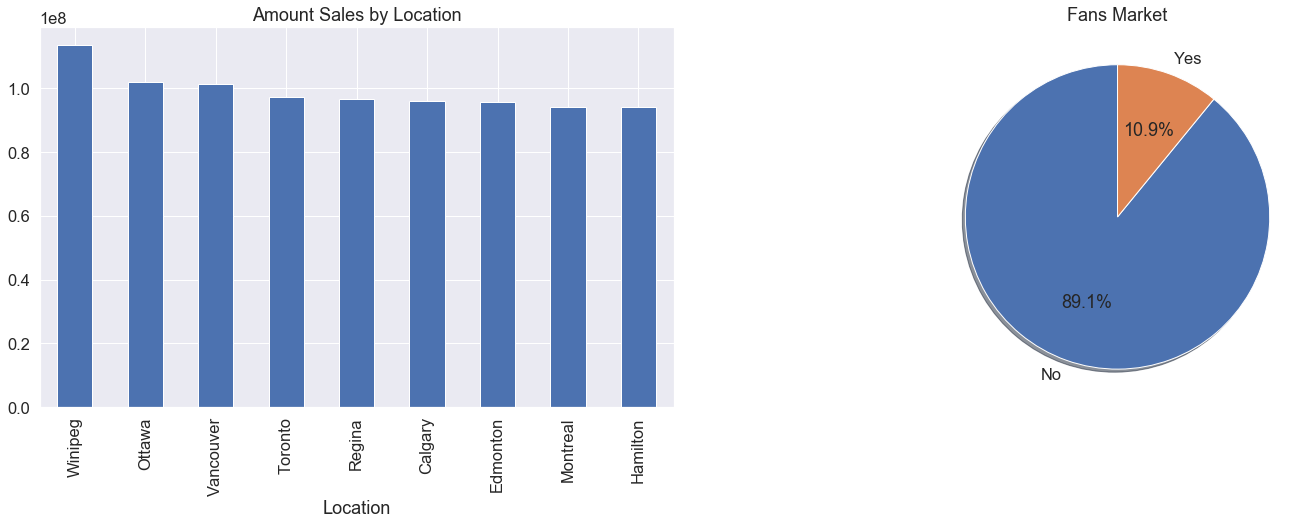

In [13]:
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
g = df.groupby(["Location"]).amount.sum().sort_values(ascending = False).plot(kind='bar', title='Amount Sales by Location')
df['Internal'] = df.Location.apply(lambda x: 'Yes' if x=='Toronto' else 'No' )
f2 = fig.add_subplot(122)
market = df.groupby(["Internal"]).amount.sum().sort_values(ascending = False)
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Fans Market')
plt.show()

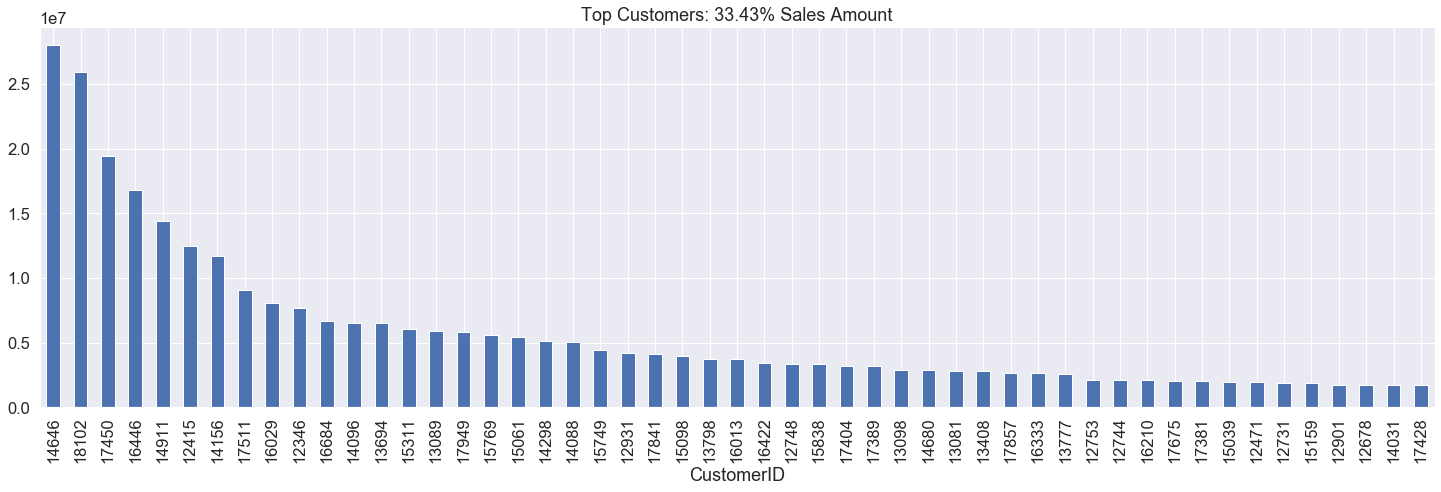

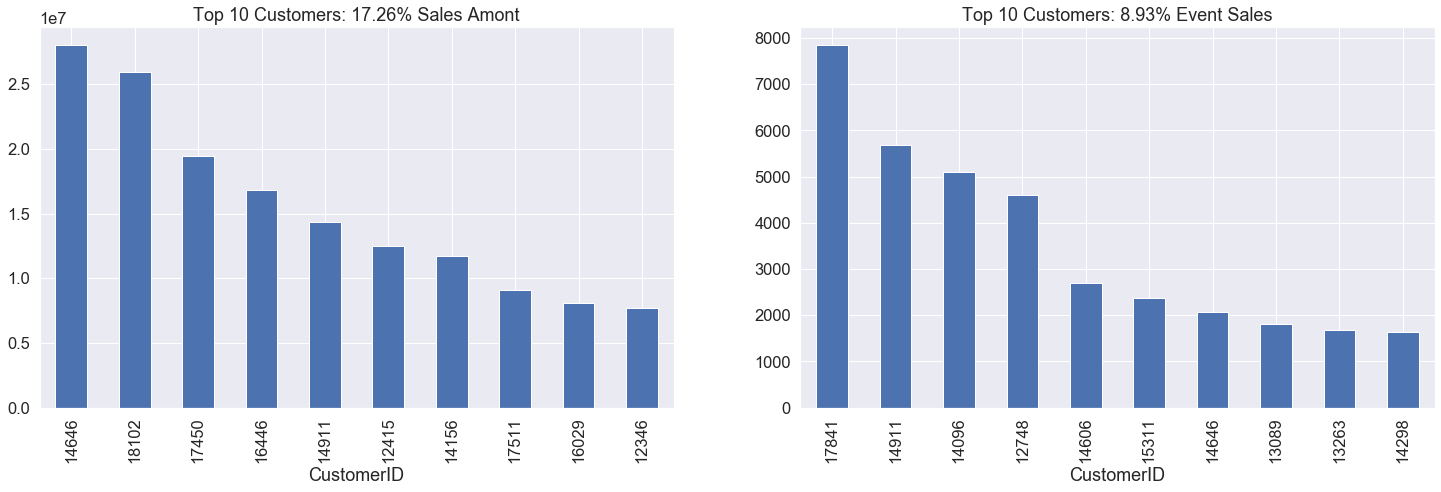

In [14]:
fig = plt.figure(figsize=(25, 7))
PercentSales =  np.round((df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:51].sum()/df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:51].\
    plot(kind='bar', title='Top Customers: {:3.2f}% Sales Amount'.format(PercentSales))

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
PercentSales =  np.round((df.groupby(["CustomerID"]).amount.sum().\
                          sort_values(ascending = False)[:10].sum()/df.groupby(["CustomerID"]).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = df.groupby(["CustomerID"]).amount.sum().sort_values(ascending = False)[:10]\
    .plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amont'.format(PercentSales))
f1 = fig.add_subplot(122)
PercentSales =  np.round((df.groupby(["CustomerID"]).amount.count().\
                          sort_values(ascending = False)[:10].sum()/df.groupby(["CustomerID"]).\
                          amount.count().sort_values(ascending = False).sum()) * 100, 2)
g = df.groupby(["CustomerID"]).amount.count().sort_values(ascending = False)[:10].\
    plot(kind='bar', title='Top 10 Customers: {:3.2f}% Event Sales'.format(PercentSales))

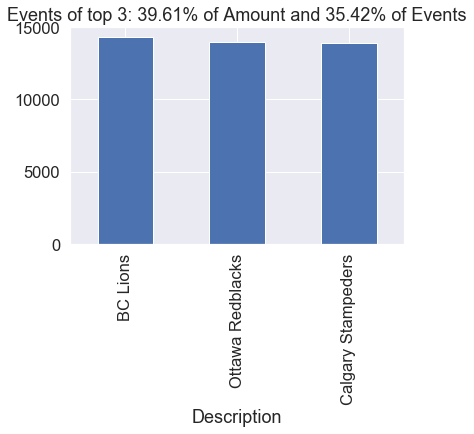

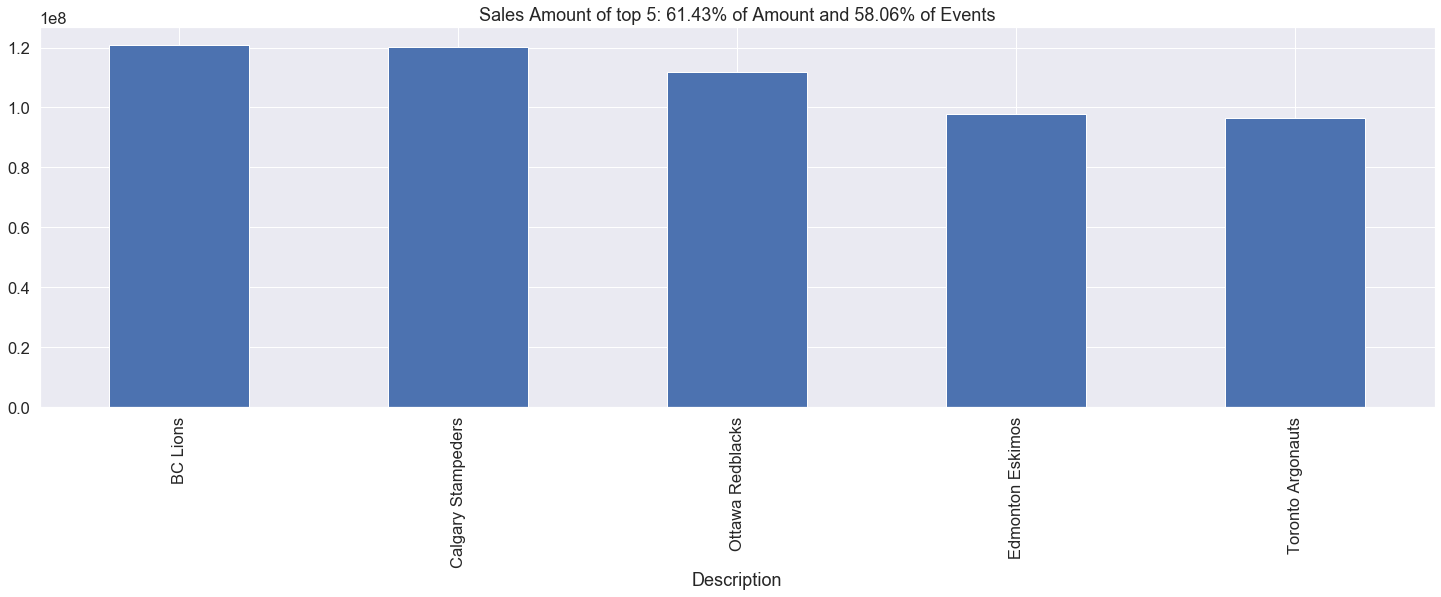

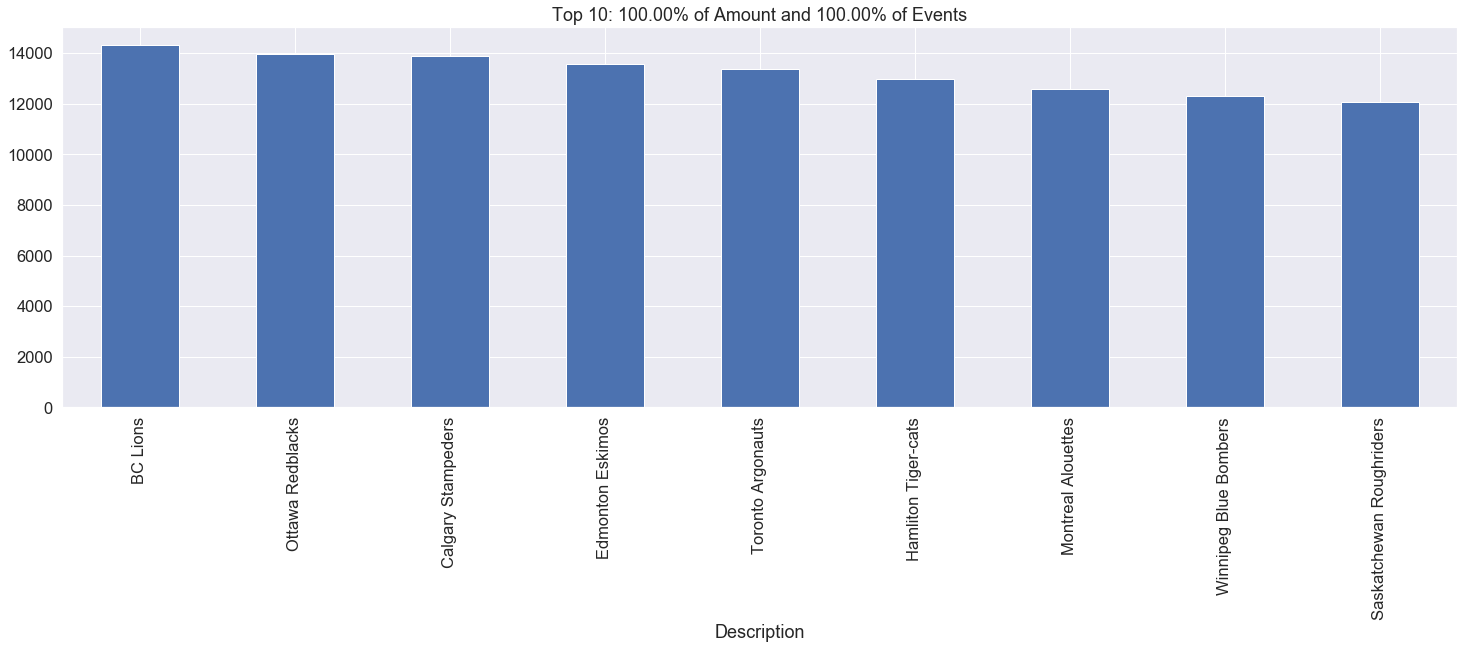

In [15]:
AmoutSum = df.groupby(["Description"]).amount.sum().sort_values(ascending = False)
inv = df[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().\
      agg(np.size).sort_values(ascending = False)

f1 = fig.add_subplot(122)
Top10Ev = list(inv[:3].index)
PercentSales =  np.round((AmoutSum[Top10Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top10Ev].\
    plot(kind='bar', title='Events of top 3: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


fig = plt.figure(figsize=(25, 7))
Top15ev = list(inv[:5].index)
PercentSales =  np.round((AmoutSum[Top15ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top15ev].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top15ev].sort_values(ascending = False).\
    plot(kind='bar', 
         title='Sales Amount of top 5: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))


fig = plt.figure(figsize=(25, 7))
Top50Ev = list(inv[:9].index)
PercentSales =  np.round((AmoutSum[Top50Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top50Ev].\
    plot(kind='bar', title='Top 10: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))



## CFL Fan Bases Segmentation:
Fan segmentation is similarly the process of dividing an CFL’s customer bases into different sections or segments based on various customer attributes.  The process of fan bases segmentation is based on the premise of finding differences among the fans’ behavior and patterns.

The major objectives and benefits behind the motivation for fan bases segmentation are:
* **Higher Revenue**: This is the most obvious requirement of any fan bases segmentation. 
* **Fans Understanding**: One of the mostly widely accepted business paradigms is “know your fans” and a segmentation of the fan base allows for a perfect dissection of this paradigm. 
* **Target Marketing**:  The most visible reason for fan bases segmentation is the ability to focus marketing efforts effectively and efficiently. If an organsization knows the different segments of its fan base, it can devise better marketing campaigns which are tailor made for the segment. A good segmentation model allows for better understanding of customer requirements and hence increases the chances of the success of any marketing campaign developed by the organization.
* **Optimal Product Placement**: A good fan bases segmentation strategy can also help the firm with developing or offering new products, or a bundle of products together as a combined offering.
* **Finding Latent Fan bases Segments**: Finding out which segment of fans it might be missing to identifying untapped fan segments by focused on marketing campaigns or new business development.




 
 
### RFM Model for Customer Value:

We will use a **RFM**,***Recency, Frequency and Monetary Value**, based model of customer value for finding our fan base segments.
 The RFM model will take the transactions of a fan and calculate three important informational attributes about each fan:
- **Recency**: The value of how recently a customer purchased at the establishment
- **Frequency**: How frequent the customer’s transactions are at the establishment
- **Monetary value**: The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment

#### Recency
To create the recency feature variable, we need to decide the reference date for our analysis. Usually, we make use of the last transaction date plus one day. Then, we will construct the recency variable as the number of days before the reference date when a customer last made a purchase.

In [16]:
refrence_date = df.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)
df['days_since_last_purchase'] = (refrence_date - df.InvoiceDate).astype('timedelta64[D]')
customer_history_df =  df[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
customer_history_df.describe().transpose()

Reference Date: 2011-12-10 12:50:00


count          mean          std      min       25%      50%  \
CustomerID  4338.0  15300.408022  1721.808492  12346.0  13813.25  15299.5   
recency     4338.0     92.536422   100.014169      1.0     18.00     51.0   

                 75%      max  
CustomerID  16778.75  18287.0  
recency       142.00    374.0

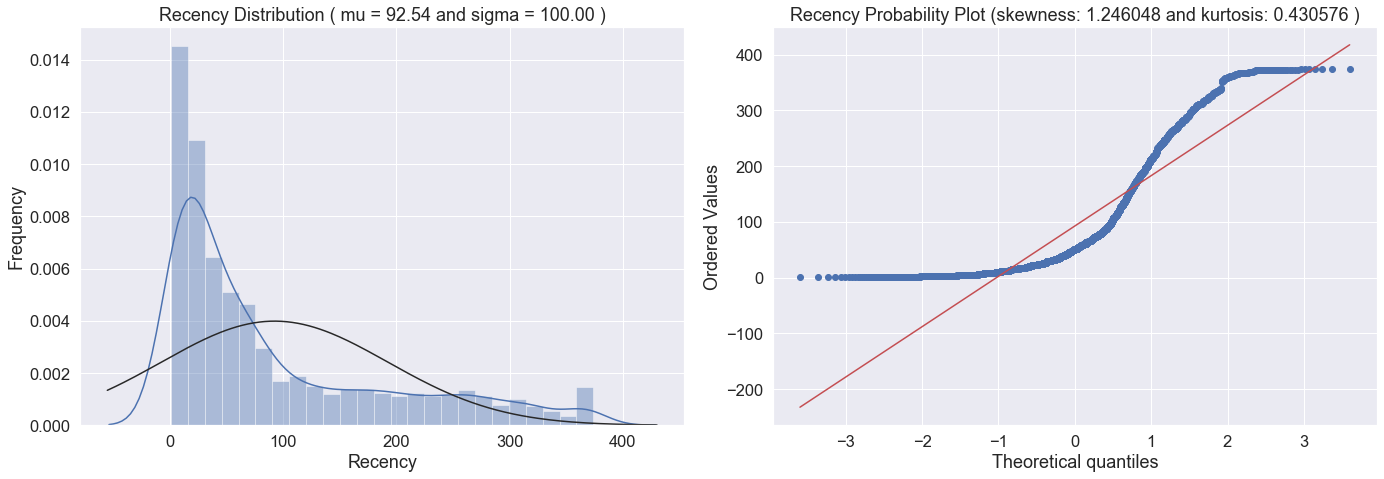

In [17]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(customer_history_df.recency, 'Recency')

#### Frequency

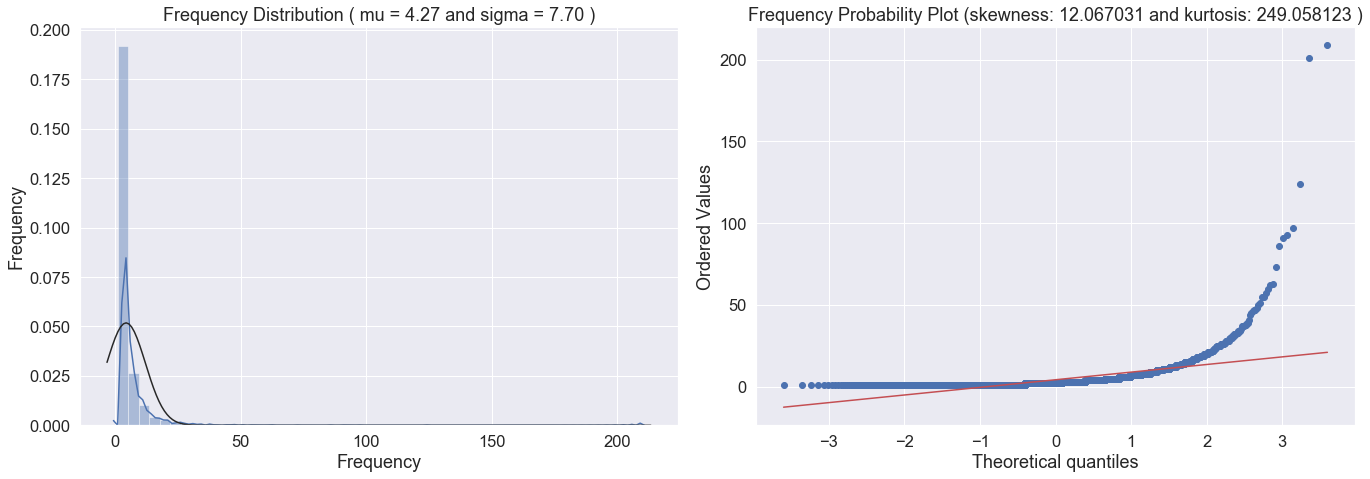

In [18]:
customer_freq = (df[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
QQ_plot(customer_history_df.frequency, 'Frequency')

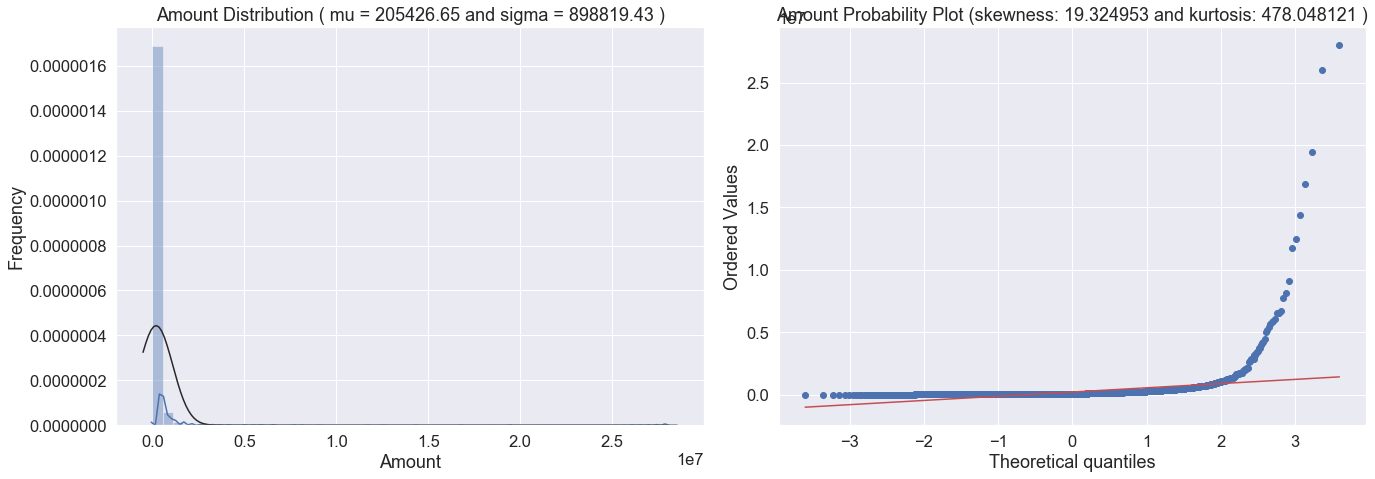

In [19]:
customer_monetary_val = df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)
QQ_plot(customer_history_df.amount, 'Amount')

In [20]:
customer_history_df.describe()

CustomerID      recency    frequency        amount
count   4338.000000  4338.000000  4338.000000  4.338000e+03
mean   15300.408022    92.536422     4.272015  2.054266e+05
std     1721.808492   100.014169     7.697998  8.989230e+05
min    12346.000000     1.000000     1.000000  3.750000e+02
25%    13813.250000    18.000000     1.000000  3.074150e+04
50%    15299.500000    51.000000     2.000000  6.744850e+04
75%    16778.750000   142.000000     5.000000  1.661740e+05
max    18287.000000   374.000000   209.000000  2.802060e+07

In [21]:
customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)
feature_vector = ['amount_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector] #.as_matrix()
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

count          mean       std       min       25%       50%  \
amount_log     4338.0 -4.381260e-16  1.000115 -4.179280 -0.684183 -0.060942   
recency_log    4338.0 -1.027980e-16  1.000115 -2.630445 -0.612424  0.114707   
frequency_log  4338.0 -2.355833e-16  1.000115 -1.048610 -1.048610 -0.279044   

                    75%       max  
amount_log     0.654244  4.721395  
recency_log    0.829652  1.505796  
frequency_log  0.738267  4.882714

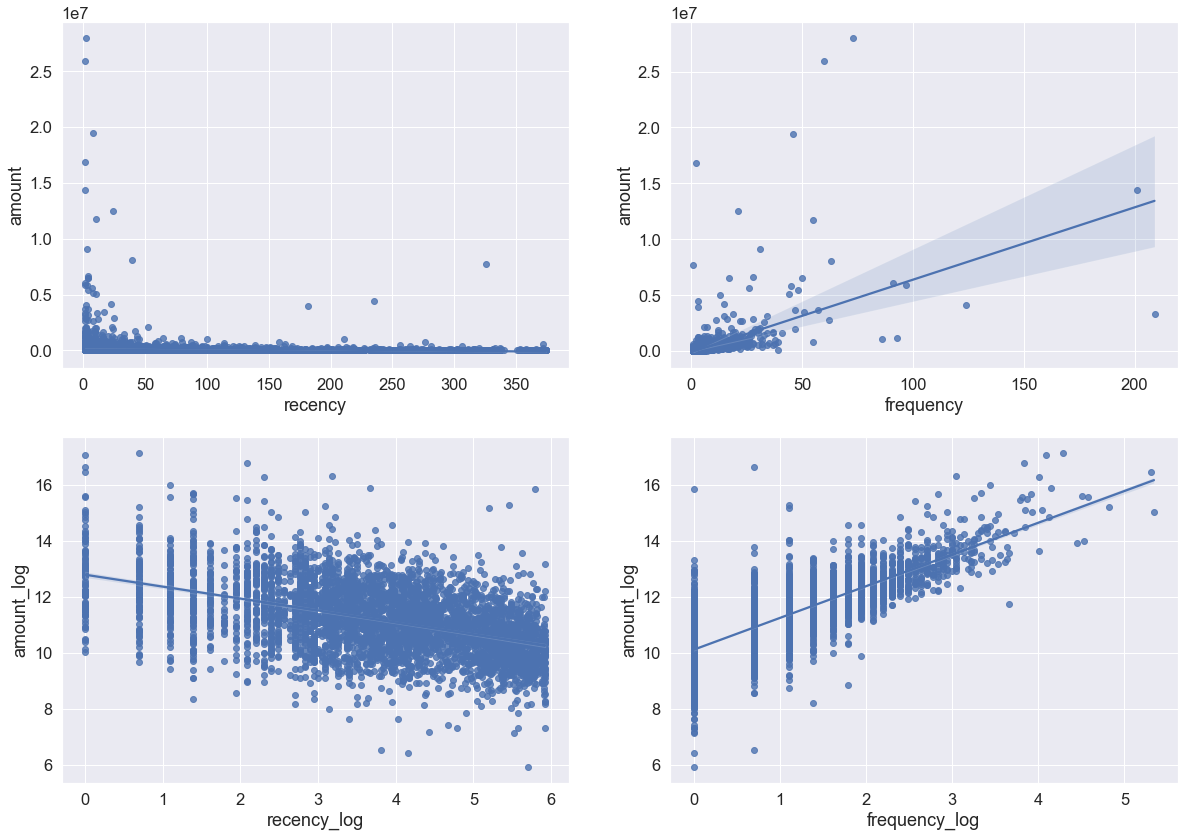

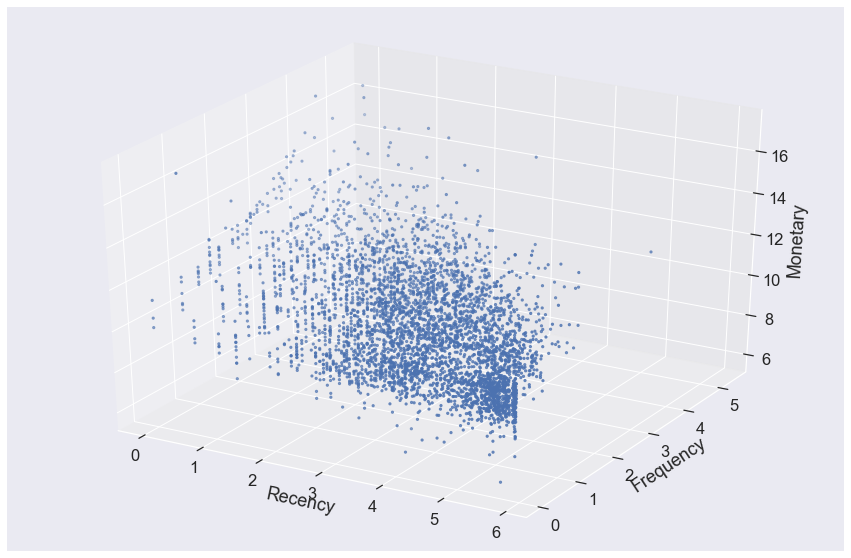

In [22]:
fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='amount_log', data=customer_history_df)
f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='amount_log', data=customer_history_df)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

### Clustering for Segments
#### K-Means Clustering

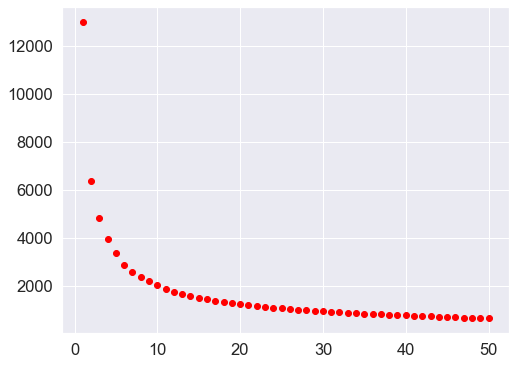

The best K sugest:  7


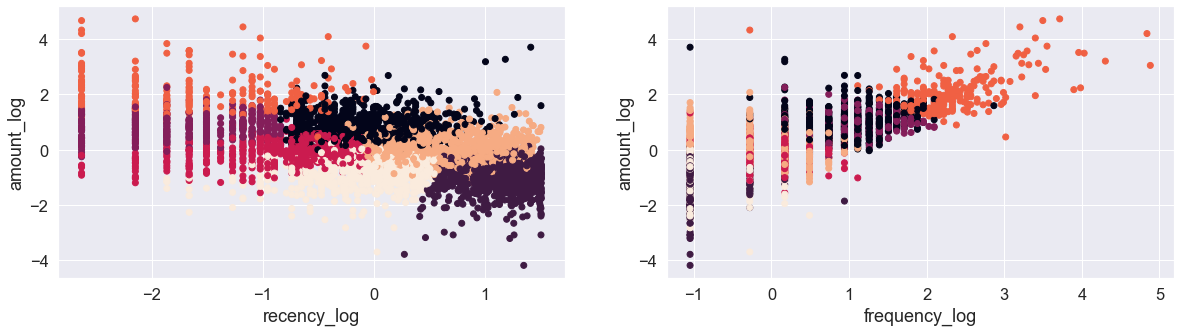

In [23]:
cl = 50
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()

# Create a kmeans model with the best K.
print('The best K sugest: ',K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])

plt.show()

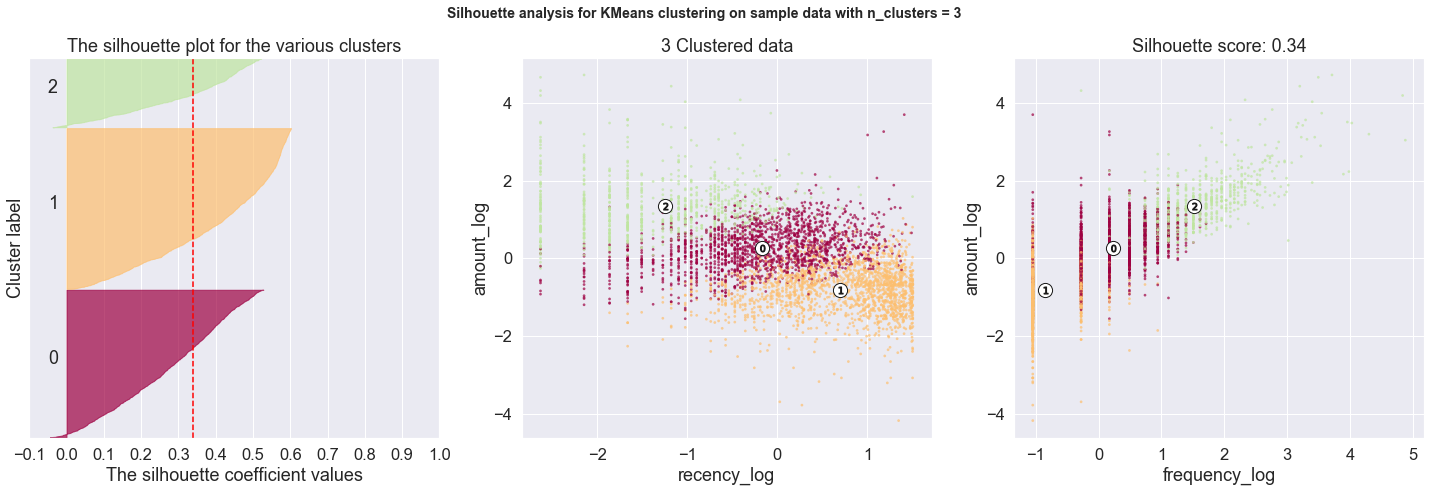

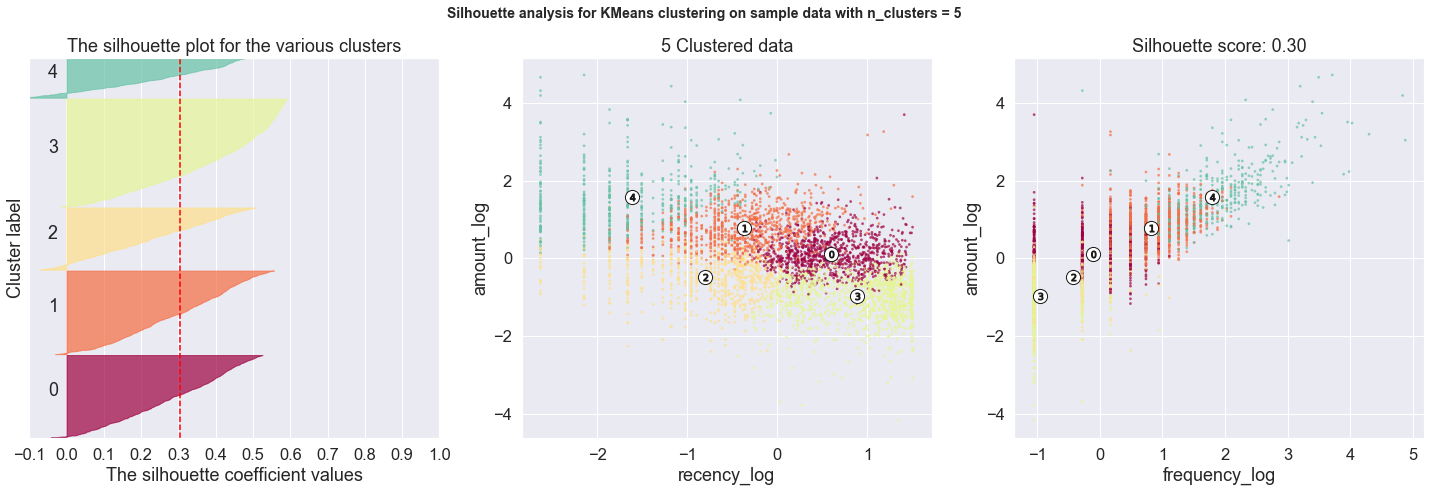

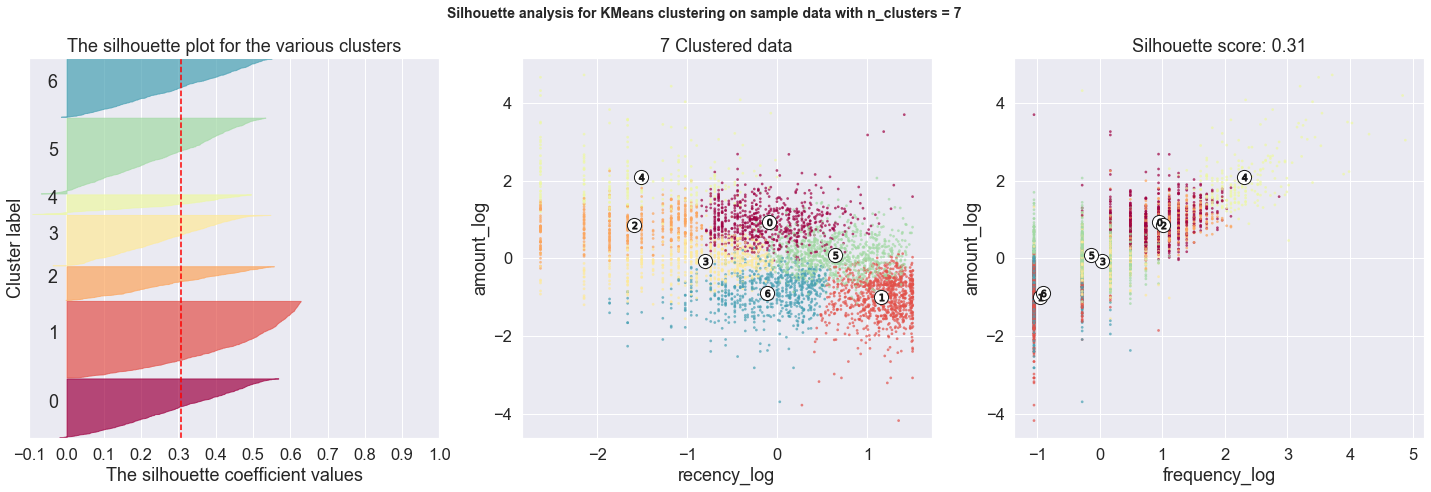

In [24]:
cluster_centers = dict()

for n_clusters in range(3,K_best+1,2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

## Insights


In [25]:
features = ['amount',  'recency',  'frequency']
for i in range(3,K_best+1,2):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.34
Centers of each cluster:
          amount     recency  frequency
0  100508.568022   33.803685   3.147476
1   26211.035842  116.805429   1.191399
2  395727.882332    7.257304  10.022628
--------------------------------------------------
for 5 clusters the silhouette score is 0.30
Centers of each cluster:
          amount     recency  frequency
0   83046.068789  101.812469   2.327423
1  197738.673675   25.374830   5.410747
2   39570.340348   13.596991   1.758879
3   21153.279380  153.659933   1.081834
4  527577.204067    4.301300  12.965088
--------------------------------------------------
for 7 clusters the silhouette score is 0.31
Centers of each cluster:
         amount     recency  frequency
0  2.402739e+05   37.806696   6.006368
1  2.052576e+04  225.386840   1.083954
2  2.114267e+05    4.458579   6.365225
3  6.597725e+04   13.663101   2.650408
4  1.014312e+06    4.926439  20.646017
5  8.145745e+04  107.556965   2.277767
6  2.399303e+04   

#### Clusters Insights:

With the plots and the center in the correct units, let's see some insights by each clusters groups:

***In the three-cluster:***
- The tree clusters appears have a good stark differences in the Monetary value of the fans
- Cluster 1 is the cluster of high value customer who shops frequently and is certainly an important segment for each business.
- In the similar way we obtain customer groups with low and medium spends in clusters with labels 0 and 2, respectively.
- Frequency and Recency correlate perfectly to the Monetary value based on the trend (High Monetary-Low Recency-High Frequency).

***In the five-cluster:***
- Note that clusters 0 and 1 are very similar to their cluster in the configuration with only 3 clusters.
- The cluster 1 appears more robust on the affirmation of those who shop often and with high amount.
- The cluster 2 are those who have a decent spend but are not as frequent as the cluster 1
- The cluster 4 purchases medium amounts, with a relatively low frequency and not very recent
- The cluster 3 makes low-cost purchases, with a relatively low frequency, but above 1, and made their last purchase more recently. This group of customers probably response to price discounts and can be subject to loyalty promotions to try increase the medium-ticket, strategy that can be better defined when we analyzing the market basket. 
- The silhouette score matrix says that the  five cluster segments are less optimal then the three cluster segments. 

***In the five-cluster:***
- Definitely cluster 6 defines those who shop often and with high amount.
- Clusters 1 and 5 show good spending and good frequency, only deferring in how recent were their last purchases, where 5 is older, which suggests an active action to sell to group 5 as soon as possible and another to 1 seeking to raise its frequency.
- Cluster 0 presents the fourth best purchase and a reasonable frequency, but this is a long time without buying. This group should be sensible to promotions and activations, so that they do not get lost and make their next purchase.
- Cluster 5 is similar to 0, but has made its purchases more recently and has a slightly better periodicity. Then actions must be taken to raise their frequency and reduce the chances of them migrating to cluster 0 by staying longer without purchasing products.

#### Drill Down Clusters:

To further drill down on this point and find out the quality of these difference, we can label our data with the corresponding cluster label and then visualize these differences. The following code will extract the clustering label and attach it with our customer summary dataset.

CustomerID  recency  frequency     amount  recency_log  frequency_log  \
0       12346    326.0          1  7718360.0     5.786897       0.000000   
1       12347      2.0          7   431000.0     0.693147       1.945910   
2       12348     75.0          4   179724.0     4.317488       1.386294   
3       12349     19.0          1   175755.0     2.944439       0.000000   
4       12350    310.0          1    33440.0     5.736572       0.000000   

   amount_log  clusters_3  clusters_5  clusters_7  
0   15.859112           0           0           0  
1   12.973863           2           4           2  
2   12.099178           0           1           0  
3   12.076846           0           2           3  
4   10.417508           1           3           1

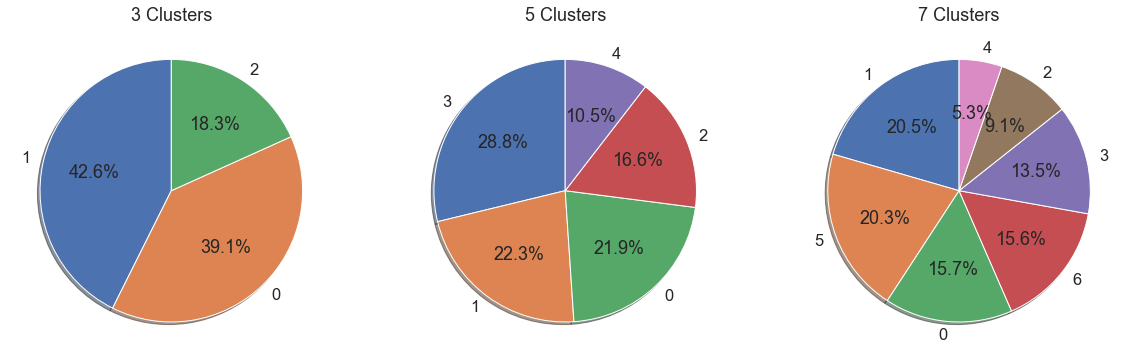

In [26]:
customer_history_df['clusters_3'] = cluster_centers[3]['labels'] 
customer_history_df['clusters_5'] = cluster_centers[5]['labels']
customer_history_df['clusters_7'] = cluster_centers[7]['labels']
display(customer_history_df.head())

fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
market = customer_history_df.clusters_3.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('3 Clusters')
f1 = fig.add_subplot(132)
market = customer_history_df.clusters_5.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('5 Clusters')
f1 = fig.add_subplot(133)
market = customer_history_df.clusters_7.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('7 Clusters')
plt.show()

### How the summary of fans in each group is varying. 
If we can visualize that information we will able to find out the differences in the clusters of fans and we can modify our strategy on the basis of those differences.


In [29]:
x_data = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 
          'rgba(22, 80, 57, 0.5)', 'rgba(127, 65, 14, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
cutoff_quantile = 95

for n_clusters in range(3,K_best+1,2):
    cl = 'clusters_' + str(n_clusters)
    for fild in range(0, 3):
        field_to_plot = features[fild]        
        y_data = list()
        ymax = 0
        for i in np.arange(0,n_clusters):
            y0 = customer_history_df[customer_history_df[cl]==i][field_to_plot].values
            y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
            if ymax < max(y0): ymax = max(y0)
            y_data.insert(i, y0)

        traces = []

        for xd, yd, cls in zip(x_data[:n_clusters], y_data, colors[:n_clusters]):
                traces.append(go.Box(y=yd, name=xd, boxpoints=False, jitter=0.5, whiskerwidth=0.2, fillcolor=cls,
                    marker=dict( size=1, ),
                    line=dict(width=1),
                ))

        layout = go.Layout(
            title='Difference in {} with {} Clusters and {:1.2f} Score'.\
            format(field_to_plot, n_clusters, cluster_centers[n_clusters]['silhouette_score']),
            yaxis=dict( autorange=True, showgrid=True, zeroline=True,
                dtick = int(ymax/10),
                gridcolor='black', gridwidth=0.1, zerolinecolor='rgb(255, 255, 255)', zerolinewidth=2, ),
            margin=dict(l=40, r=30, b=50, t=50, ),
            paper_bgcolor='white',
            plot_bgcolor='white',
            showlegend=False
        )

        fig = go.Figure(data=traces, layout=layout)
        py.offline.iplot(fig)

### Market Basket Analysis with Association Rule-Mining

In [31]:
items = list(df.Description.unique())
grouped = df.groupby('InvoiceNo')
transaction_level = grouped.aggregate(lambda x: tuple(x)).reset_index()[['InvoiceNo','Description']]
transaction_dict = {item:0 for item in items}
output_dict = dict()
temp = dict()
for rec in transaction_level.to_dict('records'):
    invoice_num = rec['InvoiceNo']
    items_list = rec['Description']
    transaction_dict = {item:0 for item in items}
    transaction_dict.update({item:1 for item in items if item in items_list})
    temp.update({invoice_num:transaction_dict})

new = [v for k,v in temp.items()]
transaction_df = pd.DataFrame(new)

In [32]:
def prune_dataset(input_df, length_trans = 2, total_sales_perc = 0.5, 
                  start_item = None, end_item = None, TopCols = None):
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending = False).reset_index()
    total_items = sum(input_df.sum().sort_values(ascending = False))
    item_count.rename(columns={item_count.columns[0]:'item_name',
                               item_count.columns[1]:'item_count'}, inplace=True)
    if TopCols: 
        input_df['total_items'] = input_df[TopCols].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[TopCols], item_count[item_count.item_name.isin(TopCols)]
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items],item_count[start_item:end_item]
    else:
        item_count['item_perc'] = item_count['item_count']/total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]

In [33]:
output_df, item_counts = prune_dataset(input_df=transaction_df, length_trans=2,start_item = 0, end_item = 15)
print('Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): {:.2f}'.format(AmoutSum[Top15ev].sum()))
print('Number of Sales Events:', output_df.shape[0])
print('Number of Products:', output_df.shape[1])

item_counts

Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): 547412517.00
Number of Sales Events: 17007
Number of Products: 9


item_name  item_count
0                  BC Lions       14315
1          Ottawa Redblacks       13955
2        Calgary Stampeders       13897
3          Edmonton Eskimos       13582
4         Toronto Argonauts       13377
5       Hamliton Tiger-cats       12964
6        Montreal Alouettes       12589
7     Winnipeg Blue Bombers       12298
8  Saskatchewan Roughriders       12081

#### Association Rule Mining with FP Growth



In [35]:
from orangecontrib.associate.fpgrowth import *
input_assoc_rules = output_df
# Defined the data domain by specifying each variable as a DiscreteVariable having values as (0, 1)
domain_transac = Domain([DiscreteVariable.make(name=item,values=['0', '1']) \
                         for item in input_assoc_rules.columns])

# Then using this domain, we created our Table structure for our data
data_tran = Orange.data.Table.from_numpy(domain=domain_transac,  
                                         X=input_assoc_rules.values,Y= None)

# Coding our input so that the entire domain is represented as binary variables
data_tran_en, mapping = OneHot.encode(data_tran, include_class=True)

In [36]:
support = 0.01
print("num of required transactions = ", int(input_assoc_rules.shape[0]*support))
num_trans = input_assoc_rules.shape[0]*support
itemsets = dict(frequent_itemsets(data_tran_en, support))
print('Items Set Size:', len(itemsets))

num of required transactions =  170
Items Set Size: 7550


In [37]:
confidence = 0.6
rules_df = pd.DataFrame()
if len(itemsets) < 1000000: 
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_tran, mapping)}
    
    eligible_ante = [v for k,v in names.items() if v.endswith("1")]
    
    N = input_assoc_rules.shape[0]
    
    rule_stats = list(rules_stats(rules, itemsets, N))
    
    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]            
        cons = ex_rule_frm_rule_stat[1]
        named_cons = names[next(iter(cons))]
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if not rules_df.empty:
        pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
    else:
        print("Unable to  any rule")

Raw rules data frame of 14473 rules generated


In [38]:
dw = pd.options.display.max_colwidth
pd.options.display.max_colwidth = 100
(rules_df[['consequent', 'antecedent', 'support','confidence','lift']].\
 groupby(['consequent', 'antecedent']).first()
                                      .reset_index()
                                      .sort_values(['confidence', 'support', 'lift'],
                                                   ascending=False)).head()

consequent  \
157             BC Lions   
1828    Ottawa Redblacks   
449   Calgary Stampeders   
1984    Ottawa Redblacks   
603   Calgary Stampeders   

                                                                                               antecedent  \
157   Ottawa Redblacks, Calgary Stampeders, Edmonton Eskimos, Toronto Argonauts, Hamliton Tiger-cats, ...   
1828  BC Lions, Calgary Stampeders, Edmonton Eskimos, Toronto Argonauts, Hamliton Tiger-cats, Montreal...   
449   BC Lions, Ottawa Redblacks, Edmonton Eskimos, Toronto Argonauts, Hamliton Tiger-cats, Montreal A...   
1984  Calgary Stampeders, Edmonton Eskimos, Toronto Argonauts, Hamliton Tiger-cats, Montreal Alouettes...   
603   Ottawa Redblacks, Edmonton Eskimos, Toronto Argonauts, Hamliton Tiger-cats, Montreal Alouettes, ...   

      support  confidence      lift  
157      5661    0.970845  1.169678  
1828     5661    0.966041  1.198356  
449      5661    0.964560  1.196169  
1984     5831    0.963961  1.195776  
603      5831    0.960626  1.191291

### Top 5 Rules

In [39]:
(rules_df[['consequent', 'antecedent', 'support','confidence','lift']].\
 groupby(['consequent', 'antecedent']).first()
                                      .reset_index()
                                      .sort_values(['support', 'confidence', 'lift'],
                                                   ascending=False)).head()

consequent                          antecedent  support  \
708   Calgary Stampeders         Toronto Argonauts, BC Lions    10329   
2139    Ottawa Redblacks         Toronto Argonauts, BC Lions    10288   
1072    Edmonton Eskimos         Toronto Argonauts, BC Lions    10035   
649   Calgary Stampeders  Saskatchewan Roughriders, BC Lions     9536   
2075    Ottawa Redblacks  Saskatchewan Roughriders, BC Lions     9421   

      confidence      lift  
708     0.889971  1.103670  
2139    0.886438  1.099610  
1072    0.864639  1.101162  
649     0.902859  1.119654  
2075    0.891971  1.106474

In [41]:
rules_df.lift.apply(lambda x: 'Greater Than One' if x > 1 else 'One' \
                           if x == 0 else 'Less Than One').value_counts()

Less Than One       7880
Greater Than One    6593
Name: lift, dtype: int64

In [42]:
pd.options.display.max_colwidth = dw